In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('drive/My Drive/UNSW/2022/data3001/datascience-cis-2022.csv')
data['easytime'] = pd.to_datetime(data['time'], unit='ns')

In [3]:
def calculate_time_index(given_day, given_hour, data):
    j = 0
    if given_hour == '00':
        for i in data.index:
            j += 1
            day = str(i)[8:10]
            if day == given_day:
                return j
    if given_day == '00':
        if len(str(given_hour)) == 1:
            given_hour = '0' + given_hour
        for i in data.index:
            j += 1
            hour = str(i)[11:13]
            if hour == given_hour:
                return j

In [4]:
day_1 = data[:1012446]
day_1_all = day_1[["ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount", "easytime"]]
day_1_all.easytime = pd.to_datetime(day_1_all.easytime)
day_1_all = day_1_all.set_index('easytime')
sum_day_1_all = day_1_all.resample('T').sum()
day_1_all

,ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount
easytime,
2022-09-02 00:24:59.417,3568
2022-09-02 00:24:59.417,1784
2022-09-02 00:24:59.417,3568
2022-09-02 00:24:59.417,3568
2022-09-02 00:24:59.417,1784
...,...
2022-09-02 23:59:49.814,0
2022-09-02 23:59:49.814,3568
2022-09-02 23:59:49.814,3568


In [5]:
sum_train = sum_day_1_all[:156]
sum_test = sum_day_1_all[156:216]
train = day_1_all[:116000]
test = day_1_all[116000:160500]

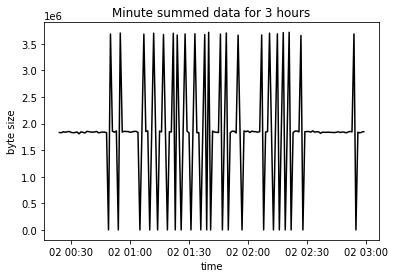

In [6]:
plt.title('Minute summed data for 3 hours')
plt.ylabel('byte size')
plt.xlabel('time')
plt.plot(sum_train, color = 'black')

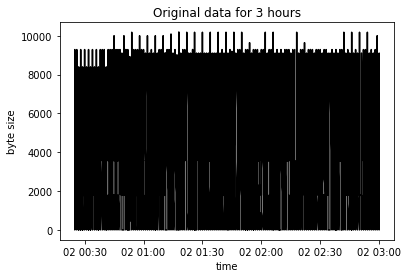

In [7]:
plt.title('Original data for 3 hours')
plt.ylabel('byte size')
plt.xlabel('time')
plt.plot(train, color = 'black')

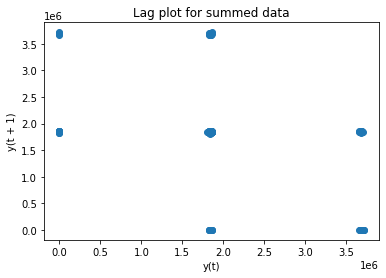

In [8]:
 plt.title('Lag plot for summed data')
 pd.plotting.lag_plot(sum_train, lag=1)

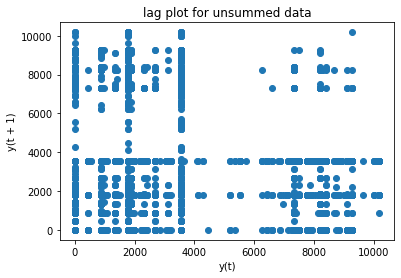

In [9]:
 plt.title('lag plot for unsummed data')
 pd.plotting.lag_plot(train, lag=1)

Test RMSE: 15552.500
1


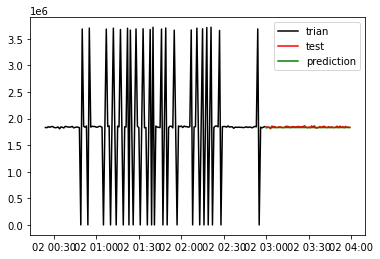

Test RMSE: 16146.129
4


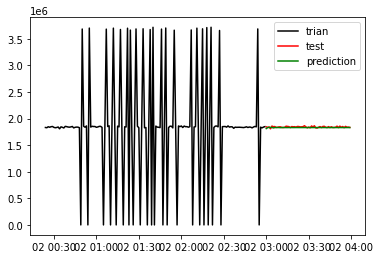

Test RMSE: 91269.282
7


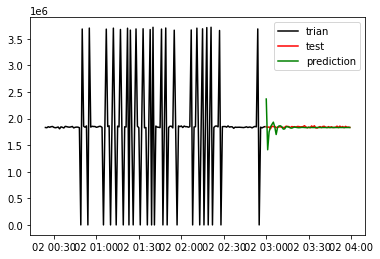

Test RMSE: 95692.058
10


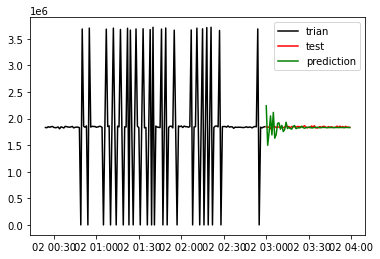

Test RMSE: 111834.448
13


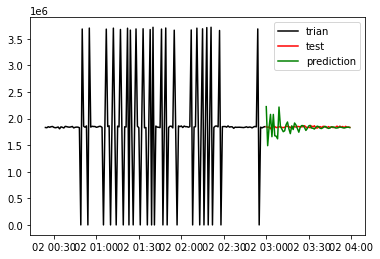

Test RMSE: 146424.398
16


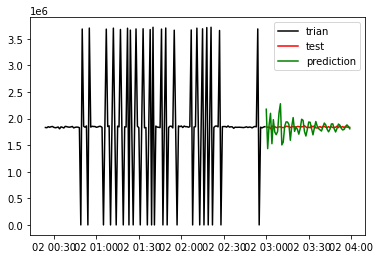

Test RMSE: 182764.369
19


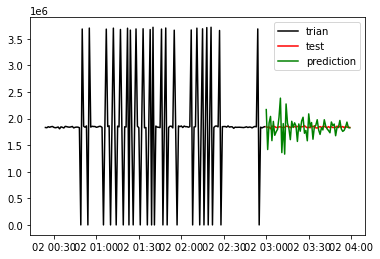

Test RMSE: 186063.191
22


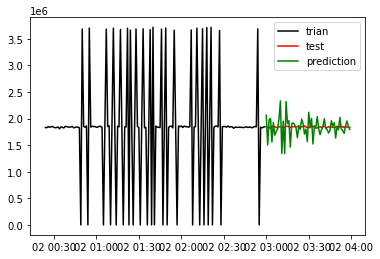

Test RMSE: 196227.643
25


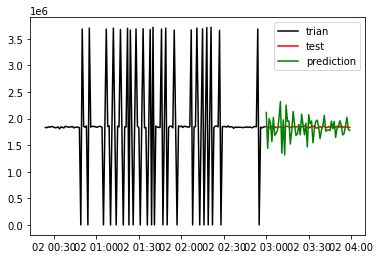

Test RMSE: 217685.500
28


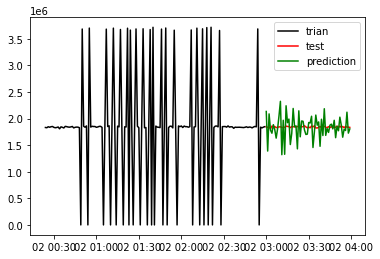

Test RMSE: 239230.719
31


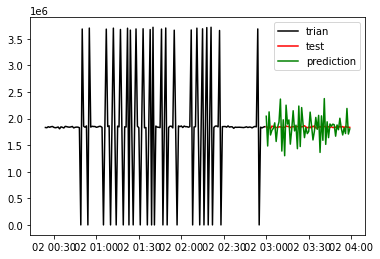

Test RMSE: 262658.716
34


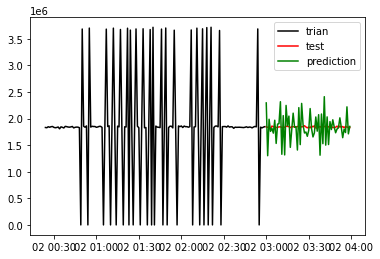

Test RMSE: 270729.177
37


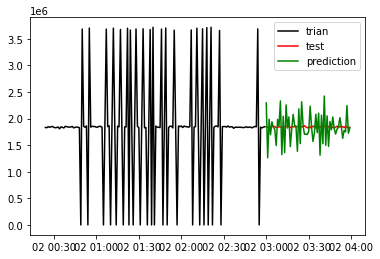

Test RMSE: 330786.102
40


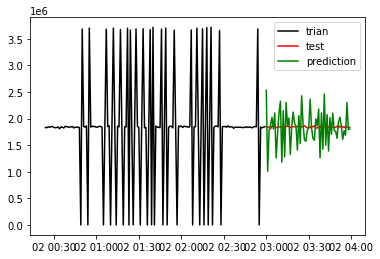

Test RMSE: 359901.070
43


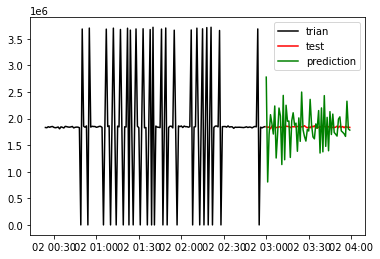

Test RMSE: 421706.042
46


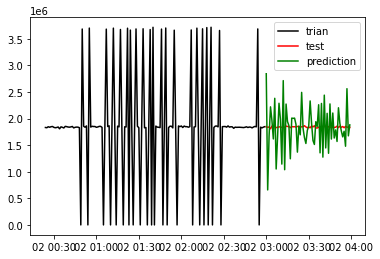

Test RMSE: 361207.885
49


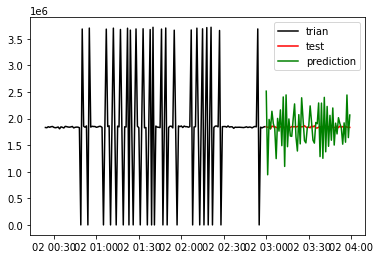

Test RMSE: 553459.989
52


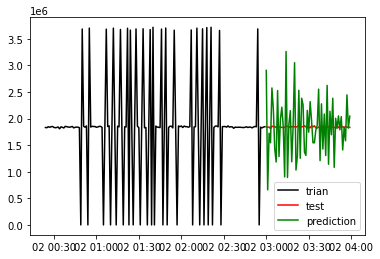

Test RMSE: 654787.935
55


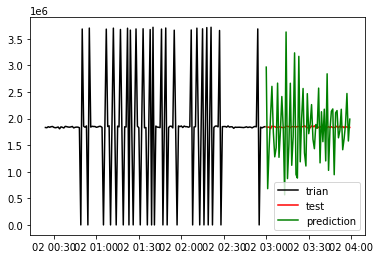

Test RMSE: 743690.196
58


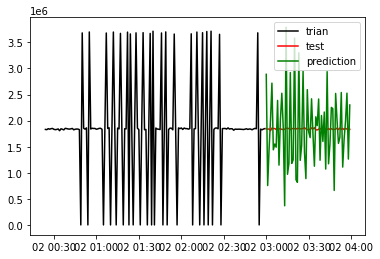

Test RMSE: 885958.272
61


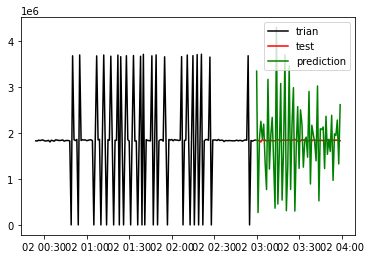

Test RMSE: 816627.716
64


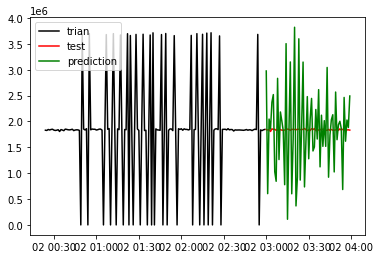

Test RMSE: 847976.882
67


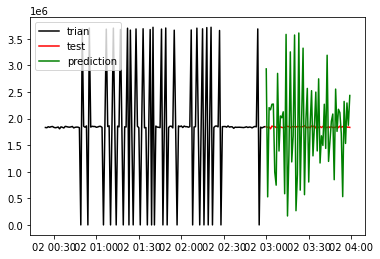

In [12]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
y = sum_train['ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount']
# train autoregression
for i in range(1, 70, 3):
    model = AutoReg(sum_train, lags=i)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(sum_train), end=len(sum_train)+len(sum_test)-1, dynamic=False)
    rmse = sqrt(mean_squared_error(sum_test, predictions))
    print('Test RMSE: %.3f' % rmse)
    print(i)
    # plot results
    plt.plot(sum_train, color = 'black')
    plt.plot(sum_test, color = 'red')
    plt.plot(predictions, color='green')
    plt.legend(["trian", "test", "prediction"])
    plt.show()

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [14]:
y = sum_train['ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount']

In [15]:
! pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import pmdarima as pm
auto_arima = pm.auto_arima(y, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(1, 0, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

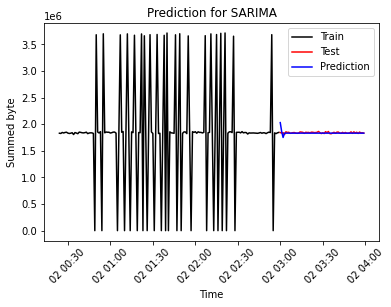

SARIMAX rmse:30343.553417507665


In [28]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse= []

SARIMAXmodel = SARIMAX(y, order = (1, 0, 4)) #USE 1,0,4 from auto arima
SARIMAXmodel = SARIMAXmodel.fit()
y_pred = SARIMAXmodel.get_forecast(len(sum_test.index))
y_pred_df = y_pred.conf_int(alpha = 0.1) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = sum_test.index
y_pred_out = y_pred_df["Predictions"] 
sarimax_rmse = np.sqrt(mean_squared_error(sum_test['ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount'].values, y_pred_df["Predictions"]))
plt.plot(sum_train, color = "black")
plt.plot(sum_test, color = "red")
plt.ylabel('Summed byte')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.title("Prediction for SARIMA")
plt.plot(y_pred_out, color='blue', label = 'Predictions')
plt.legend(['Train', 'Test','Prediction'])
plt.show()
print(f'SARIMAX rmse:{sarimax_rmse}')

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


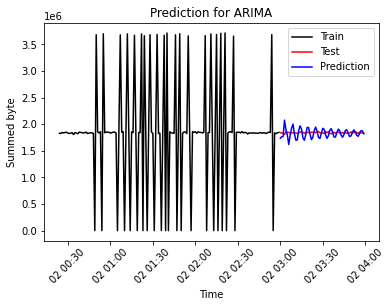

ARIMA rmse: 87293.95875285714


In [29]:
from statsmodels.tsa.arima.model import ARIMA
ARIMAmodel = ARIMA(y, order = (3, 0, 4)) #USE 1,0,4 from auto arima
ARIMAmodel = ARIMAmodel.fit()
y_pred = ARIMAmodel.get_forecast(len(sum_test.index))
y_pred_df = y_pred.conf_int(alpha = 0.1) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = sum_test.index
y_pred_out = y_pred_df["Predictions"] 
arima_rmse = np.sqrt(mean_squared_error(sum_test['ToInternetRSVPPortAllIPurn:ietf:params:mud:controllerByteCount'].values, y_pred_df["Predictions"]))
plt.plot(sum_train, color = "black")
plt.plot(sum_test, color = "red")
plt.ylabel('Summed byte')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.title("Prediction for ARIMA")
plt.plot(y_pred_out, color='blue', label = 'Predictions')
plt.legend(['Train', 'Test','Prediction'])
plt.show()
print(f"ARIMA rmse: {arima_rmse}")